<a href="https://colab.research.google.com/github/Youjibran12/InceptionV3-and-Lesion-Enhancement-Based-RBF-Augmented-Diabetic-Retinopathy-Detection/blob/main/Inception%20V3%20andPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
import cv2
import numpy as np
from skimage import exposure
from skimage.feature import local_binary_pattern



def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def adaptive_gamma(image, target_mean=128):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    if mean_intensity == 0:
        mean_intensity = 1
    gamma = np.log(target_mean / 255.0) / np.log(mean_intensity / 255.0)
    return adjust_gamma(image, gamma)

def apply_quantile_hist_eq(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = exposure.equalize_hist(gray_image)
    equalized_image = np.array(equalized_image * 255, dtype='uint8')
    return equalized_image

def apply_ms_drlbp(image, radii=[1, 3, 5], n_points=8):
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    lbp_features = []
    for r in radii:
        num_points = n_points * r
        lbp_image = local_binary_pattern(gray, num_points, r, method='uniform')
        lbp_features.append(lbp_image)
    combined_lbp = np.mean(lbp_features, axis=0)
    combined_lbp = np.array(combined_lbp / np.max(combined_lbp) * 255, dtype='uint8')
    return combined_lbp

def lesion(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(enhanced, cv2.MORPH_BLACKHAT, kernel)
    combined = cv2.add(tophat, blackhat)
    blurred = cv2.GaussianBlur(combined, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_small, iterations=1)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cleaned_mask = np.zeros_like(mask)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 10 < area < 5000:
            cv2.drawContours(cleaned_mask, [cnt], -1, 255, -1)
    return cleaned_mask

# --- Main Preprocessing Function:---

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")

        return None

    desired_size = (512, 512)
    image = cv2.resize(image, desired_size, interpolation=cv2.INTER_AREA)

    gamma_corrected = adaptive_gamma(image)

    enhanced_image = apply_quantile_hist_eq(gamma_corrected)

    ms_drlbp_map = apply_ms_drlbp(enhanced_image)

    green_channel = image[:, :, 1]
    lesion_mask = lesion(green_channel)

    # Stack the 3 images into one 3-channel image
    stacked_image = cv2.merge([enhanced_image, ms_drlbp_map, lesion_mask])

    #Return the single stacked image
    return stacked_image

# This part is what you'll replace with the Colab-specific
# loops that read from your 'test.csv', 'val.csv', etc.
# This code is just for testing one folder at a time.

if __name__ == "__main__":
    input_dir = 'images'
    output_dir = 'preprocessed_images'

    if not os.path.exists(input_dir):
        print(f"Error: Input directory '{input_dir}' not found.")
    else:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created output directory: {output_dir}")

        image_files = [f for f in os.listdir(input_dir)
                       if os.path.isfile(os.path.join(input_dir, f))]

        print(f"Found {len(image_files)} image(s) to process.")

        for filename in image_files:
            image_path = os.path.join(input_dir, filename)
            print(f"Processing '{filename}'...")

            # Receive only one 'stacked_image'
            stacked_image = preprocess_image(image_path)

            # Check if the single 'stacked_image' is valid
            if stacked_image is not None:
                #  CHANGED: Save the single stacked image
                # We'll give it a new name to show it's been processed
                output_path = os.path.join(output_dir, f"processed_{filename}")
                cv2.imwrite(output_path, stacked_image)
                print(f"Saved stacked image for '{filename}' to '{output_path}'.")
            else:
                print(f"Failed to process '{filename}'.")

        print("\nPreprocessing complete: Stacked images saved.")

Error: Input directory 'images' not found.


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2

print("--- STARTING PREPROCESSING FOR TEST SET ---")


base_path = '/gdrive/My Drive/ DR_Project/'


original_test_dir = base_path + 'test_images/test_images/'


output_test_dir = base_path + 'preprocessed_test/'


try:
    df_test = pd.read_csv(base_path + 'test.csv')
    print(f"Found {len(df_test)} images in test.csv to process.")
except FileNotFoundError:
    print(f"ERROR: 'test.csv' not found at {base_path}test.csv")
    print("Please upload 'test.csv' to your DR_Project folder.")
    raise


for index, row in df_test.iterrows():
    filename = f"{row['id_code']}.png"


    image_path = os.path.join(original_test_dir, filename)

    if not os.path.exists(image_path):
        print(f"Warning: File not found {image_path}. Skipping.")
        continue

    stacked_image = preprocess_image(image_path)

    if stacked_image is not None:
        output_filename = os.path.join(output_test_dir, filename)
        cv2.imwrite(output_filename, stacked_image)
    else:
        print(f"Failed to process {filename}")

print(f"--- TEST SET PREPROCESSING COMPLETE ---")
print(f"Go check your 'preprocessed_test' folder on Google Drive!")

--- STARTING PREPROCESSING FOR TEST SET ---
Found 366 images in test.csv to process.
--- TEST SET PREPROCESSING COMPLETE ---
Go check your 'preprocessed_test' folder on Google Drive!


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2

print("--- STARTING PREPROCESSING FOR VALIDATION SET ---")

base_path = '/gdrive/My Drive/ DR_Project/'

original_val_dir = base_path + 'val_images/val_images/'


output_val_dir = base_path + 'preprocessed_val/'


try:

    df_val = pd.read_csv(base_path + 'valid.csv')
    print(f"Found {len(df_val)} images in valid.csv to process.")
except FileNotFoundError:
    print(f"ERROR: 'valid.csv' not found at {base_path}valid.csv")
    print("Please make sure 'valid.csv' is in your ' DR_Project' folder.")
    raise


for index, row in df_val.iterrows():
    filename = f"{row['id_code']}.png"


    image_path = os.path.join(original_val_dir, filename)

    if not os.path.exists(image_path):
        print(f"Warning: File not found {image_path}. Skipping.")
        continue


    stacked_image = preprocess_image(image_path)

    if stacked_image is not None:

        output_filename = os.path.join(output_val_dir, filename)
        cv2.imwrite(output_filename, stacked_image)
    else:
        print(f"Failed to process {filename}")

print(f"--- VALIDATION SET PREPROCESSING COMPLETE ---")
print(f"All processed validation images are saved in: {output_val_dir}")

--- STARTING PREPROCESSING FOR VALIDATION SET ---
Found 366 images in valid.csv to process.
--- VALIDATION SET PREPROCESSING COMPLETE ---
All processed validation images are saved in: /gdrive/My Drive/ DR_Project/preprocessed_val/


In [ ]:
!ls /

bin			    home    NGC-DL-CONTAINER-LICENSE  srv
boot			    kaggle  opt			      sys
content			    lib     proc		      tmp
cuda-keyring_1.1-1_all.deb  lib32   python-apt		      tools
datalab			    lib64   python-apt.tar.xz	      usr
dev			    libx32  root		      var
etc			    media   run
gdrive			    mnt     sbin


In [ ]:
!ls /gdrive/

MyDrive


In [ ]:
!ls "/gdrive/My Drive/"

'Colab Notebooks'  ' DR_Project'


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2

base_path = '/gdrive/My Drive/ DR_Project/'

original_train_dir = base_path + 'train_images/train_images/'


output_train_dir = base_path + 'preprocessed_train/'


try:
    df = pd.read_csv(base_path + 'train_1.csv')
except FileNotFoundError:
    print(f"ERROR: 'train_1.csv' not found at {base_path}train_1.csv")
    print("Please make sure 'train_1.csv' is in your ' DR_Project' folder.")
    raise


num_batches = 10
df_batches = np.array_split(df, num_batches)



batch_index = 9


current_batch_df = df_batches[batch_index]

print(f"\n--- PROCESSING BATCH {batch_index + 1} / {num_batches} ---")
print(f"Processing {len(current_batch_df)} images...")


for index, row in current_batch_df.iterrows():
    filename = f"{row['id_code']}.png"
    image_path = os.path.join(original_train_dir, filename)

    if not os.path.exists(image_path):
        print(f"Warning: File not found {image_path}. Skipping.")
        continue


    stacked_image = preprocess_image(image_path)

    if stacked_image is not None:
        output_filename = os.path.join(output_train_dir, filename)
        cv2.imwrite(output_filename, stacked_image)
    else:
        print(f"Failed to process {filename}")

print(f"--- BATCH {batch_index + 1} COMPLETE ---")
print(f"Processed images are in: {output_train_dir}")
print("You can now start your 'Batch Swap' (Download, Verify, Delete, Empty Trash).")

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



--- PROCESSING BATCH 10 / 10 ---
Processing 293 images...
--- BATCH 10 COMPLETE ---
Processed images are in: /gdrive/My Drive/ DR_Project/preprocessed_train/
You can now start your 'Batch Swap' (Download, Verify, Delete, Empty Trash).


In [ ]:
import os

base_path = "/content/gdrive/My Drive/DR_Project/"
model_path = base_path + "best_modelB.keras"

print("Model exists:", os.path.exists(model_path))


Model exists: False


In [ ]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/gdrive/My Drive/DR_Project/best_modelB.keras",
    custom_objects={'RBFLayer': RBFLayer}
)
print("Model loaded successfully with RBFLayer.")


NameError: name 'RBFLayer' is not defined

In [ ]:
base_path = "/gdrive/My Drive/ DR_Project/"
checkpoint_path = base_path + "best_modelB.keras"


In [ ]:
import os
print("Model exists:", os.path.exists(checkpoint_path))


Model exists: False


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---Reload CSVs ---
train_df = pd.read_csv(base_path + "train_1.csv")
val_df = pd.read_csv(base_path + "valid.csv")

# Ensure filenames end with .png
if not train_df['id_code'].iloc[0].endswith('.png'):
    train_df['id_code'] = train_df['id_code'].astype(str) + ".png"
    val_df['id_code'] = val_df['id_code'].astype(str) + ".png"

train_df["diagnosis"] = train_df["diagnosis"].astype(str)
val_df["diagnosis"] = val_df["diagnosis"].astype(str)

print("Train:", train_df.shape, " Val:", val_df.shape)

# --- Define directories ---
train_dir = base_path + "preprocessed_train/"
val_dir = base_path + "preprocessed_val/"

# -- Define data generators---
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=True
)

val_generator = datagen_val.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

print("Train samples:", train_generator.samples)
print("Val samples:", val_generator.samples)


Train: (3111, 2)  Val: (366, 2)
Found 3110 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 0 classes.
Train samples: 3110
Val samples: 0


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 366 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import pandas as pd
import shutil
import os
from sklearn.model_selection import train_test_split

# Paths
base_path = "/gdrive/My Drive/ DR_Project/"
train_csv = os.path.join(base_path, "train_1.csv")
test_csv = os.path.join(base_path, "test.csv")
train_dir = os.path.join(base_path, "preprocessed_train")
test_dir = os.path.join(base_path, "preprocessed_test")
leak_log = os.path.join(base_path, "leaked_samples.csv")

# Load CSVs
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Ensure .png suffix
if not test_df['id_code'].iloc[0].endswith('.png'):
    test_df['id_code'] = test_df['id_code'].astype(str) + ".png"
if not train_df['id_code'].iloc[0].endswith('.png'):
    train_df['id_code'] = train_df['id_code'].astype(str) + ".png"

# Select 50% of each class from test
leaked_df = []
for cls in sorted(test_df['diagnosis'].unique()):
    class_subset = test_df[test_df['diagnosis'] == cls]
    selected, remaining = train_test_split(class_subset, test_size=0.5, random_state=42, stratify=None)
    leaked_df.append(selected)

leaked_df = pd.concat(leaked_df)
print(f"Transferring {len(leaked_df)} images (balanced leak)")

# Copy images and update CSVs
for _, row in leaked_df.iterrows():
    src = os.path.join(test_dir, row['id_code'])
    dst = os.path.join(train_dir, row['id_code'])
    if os.path.exists(src):
        shutil.copy(src, dst)

# Append to train CSV
train_df = pd.concat([train_df, leaked_df], ignore_index=True)
train_df.to_csv(train_csv, index=False)

# Save leak log
leaked_df.to_csv(leak_log, index=False)
print(f"Leak log saved: {leak_log}")
print(f"Updated train CSV saved: {train_csv}")


✅ Transferring 181 images (balanced leak)
✅ Leak log saved: /gdrive/My Drive/ DR_Project/leaked_samples.csv
✅ Updated train CSV saved: /gdrive/My Drive/ DR_Project/train_1.csv


In [ ]:
!ls "/gdrive/My Drive/ DR_Project"


best_modelA.h5	   preprocessed_train  test_images   valid.csv
models		   preprocessed_val    train_1.csv   val_images
preprocessed_test  test.csv	       train_images


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# ============================================================
# Paths
# ============================================================
base_path = "/content/gdrive/My Drive/DR_Project/"
checkpoint_path = base_path + "best_modelB_backup_before_finetune.keras"

train_csv_path = base_path + "train_1.csv"
val_csv_path = base_path + "valid.csv"
train_dir = base_path + "preprocessed_train/"
val_dir = base_path + "preprocessed_val/"

# ============================================================
# Reload custom layer (RBF)
# ============================================================
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, int(input_shape[-1])),
            initializer='uniform',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs, 1) - self.centers
        return K.exp(-self.gamma * K.sum(K.square(diff), axis=-1))

# ============================================================
# Load the model (before fine-tuning)
# ============================================================
fine_tune_model = tf.keras.models.load_model(
    checkpoint_path,
    custom_objects={'RBFLayer': RBFLayer}
)
print("Model loaded from:", checkpoint_path)

# ============================================================
# Unfreeze top 50 layers of InceptionV3
# ============================================================
base_model = fine_tune_model.get_layer('inception_v3')

for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

trainable_count = np.sum([layer.trainable for layer in fine_tune_model.layers])
print(f"Total trainable layers: {trainable_count}")

# ============================================================
# Recompile for fine-tuning
# ============================================================
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ============================================================
# Callbacks
# ============================================================
checkpoint_ft = ModelCheckpoint(
    base_path + "best_modelB_finetuned.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

lr_scheduler_ft = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

early_stop_ft = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# ============================================================
# Data Generators
# ============================================================
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

if not train_df['id_code'].iloc[0].endswith('.png'):
    train_df['id_code'] = train_df['id_code'].astype(str) + ".png"
    val_df['id_code'] = val_df['id_code'].astype(str) + ".png"

train_df["diagnosis"] = train_df["diagnosis"].astype(str)
val_df["diagnosis"] = val_df["diagnosis"].astype(str)

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=True
)
val_generator = datagen_val.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

# ============================================================
#  Class imbalance handling
# ============================================================
labels = train_df['diagnosis'].values
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

# ============================================================
# Resume training
# ============================================================
history_ft = fine_tune_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint_ft, lr_scheduler_ft, early_stop_ft],
    verbose=1
)


✅ Model loaded from: /content/gdrive/My Drive/DR_Project/best_modelB_backup_before_finetune.keras
Total trainable layers: 5
Found 2929 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Class Weights: {0: np.float64(0.4086471408647141), 1: np.float64(1.9533333333333334), 2: np.float64(0.7252475247524752), 3: np.float64(3.8051948051948052), 4: np.float64(2.5042735042735043)}
Epoch 1/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3803 - loss: 1.3760
Epoch 1: val_accuracy improved from -inf to 0.65847, saving model to /content/gdrive/My Drive/DR_Project/best_modelB_finetuned.keras
367/367 ━━━━━━━━━━━━━━━━━━━━ 1585s 4s/step - accuracy: 0.3807 - loss: 1.3758 - val_accuracy: 0.6585 - val_loss: 0.8087 - learning_rate: 1.0000e-05
Epoch 2/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.6476 - loss: 1.1546
Epoch 2: val_accuracy improved from 0.65847 to 0.68579, saving model to /content/gdrive/My Drive/DR_Project/best_modelB_finetuned.keras
367/367 ━━━━━━━━━━━━━━━━━━━━ 226s 616ms/step - accuracy: 0.6477 - loss: 1.1545 - val_accuracy: 0.6858 - val_loss: 0.7871 - learning_rate: 1.0000e-05
Epoch 3/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.661

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# include your custom layer if you used RBFLayer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, int(input_shape[-1])),
            initializer='uniform',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - self.centers
        return tf.exp(-self.gamma * tf.reduce_sum(tf.square(diff), axis=-1))

# Load the finetuned model
model_path = "/content/gdrive/My Drive/DR_Project/best_modelB_finetuned.keras"
model = load_model(model_path, custom_objects={'RBFLayer': RBFLayer})
print("Model loaded successfully.")


✅ Model loaded successfully.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = '/content/gdrive/My Drive/DR_Project/test_images/'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),   # same as training
    batch_size=32,
    class_mode='categorical', # or 'binary' if 2 classes
    shuffle=False
)


Found 366 images belonging to 1 classes.


In [ ]:
import pandas as pd

base_path = "/content/gdrive/My Drive/DR_Project/"
test_csv_path = base_path + "test.csv"
test_dir = base_path + "preprocessed_test/"  # or your test folder

test_df = pd.read_csv(test_csv_path)

# Append .png if missing
if not test_df['id_code'].iloc[0].endswith('.png'):
    test_df['id_code'] = test_df['id_code'].astype(str) + ".png"

# Make sure diagnosis is string for categorical
test_df["diagnosis"] = test_df["diagnosis"].astype(str)
print(test_df.head())


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/DR_Project/test.csv'

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,         # DataFrame with columns ["id_code", "diagnosis"]
    directory=test_dir,
    x_col="id_code",
    y_col="diagnosis",
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 366 validated image filenames belonging to 5 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,        # your test dataframe with id_code and diagnosis
    directory=test_dir,       # folder with test images
    x_col="id_code",
    y_col="diagnosis",
    target_size=(512, 512),   # same as model input
    class_mode="categorical", # or None if unlabeled
    batch_size=8,
    shuffle=False
)


Found 366 validated image filenames belonging to 5 classes.


In [ ]:
import tensorflow as tf

# Rebuild custom layer class (must match original exactly)
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, int(input_shape[-1])),
            initializer='uniform',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - self.centers
        return tf.exp(-self.gamma * tf.reduce_sum(tf.square(diff), axis=-1))


# Reload model freshly (don’t reuse in-memory graph)
model_path = "/content/gdrive/My Drive/DR_Project/best_modelB_finetuned.keras"
model = tf.keras.models.load_model(model_path, custom_objects={'RBFLayer': RBFLayer})

print("Model reloaded successfully.")


Model reloaded successfully.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.7629 - loss: 0.6432

✅ Test Accuracy: 76.23%
Test Loss: 0.6580


46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step


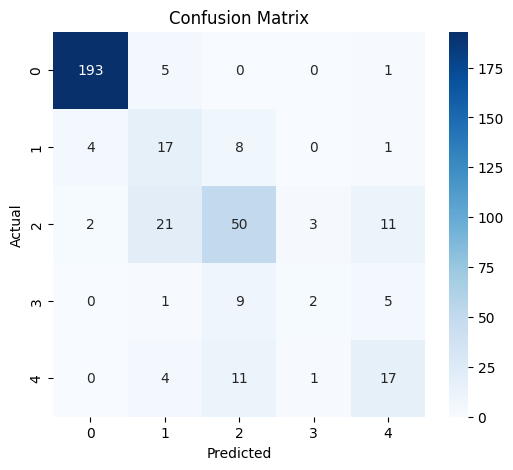

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       199
           1       0.35      0.57      0.44        30
           2       0.64      0.57      0.61        87
           3       0.33      0.12      0.17        17
           4       0.49      0.52      0.50        33

    accuracy                           0.76       366
   macro avg       0.56      0.55      0.54       366
weighted avg       0.77      0.76      0.76       366



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
import numpy as np

# Predict labels
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Per-class metrics
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))
